In [88]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd
import seaborn as sns
import numpy as np

In [91]:
from sklearn import cluster
from sklearn import preprocessing
import folium
from folium import plugins
from folium.plugins import HeatMap

In [92]:
import io
from PIL import Image

#### BBOX useful to download data from Flickr with an API

In [93]:
stgo = 'Provincia de Santiago, Región Metropolitana de Santiago, Chile'

In [94]:
area_stgo = ox.geocode_to_gdf(stgo)

In [95]:
area_stgo.total_bounds

array([-70.9552155, -33.6274799, -70.176148 , -33.0969351])

#### We bring data extracted from Flickr years 2017-2019

In [96]:
stgo_flickr = pd.read_json('../Chile/Santiago_flickr_photos2019.json')

In [97]:
pd.set_option('display.max_columns', None)

In [99]:
stgo_flickr_gdf = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            stgo_flickr["longitude"], stgo_flickr["latitude"]
        )
    }, crs="EPSG:4326"
).join(stgo_flickr)

#### Map of pictures taken in 2017-2019

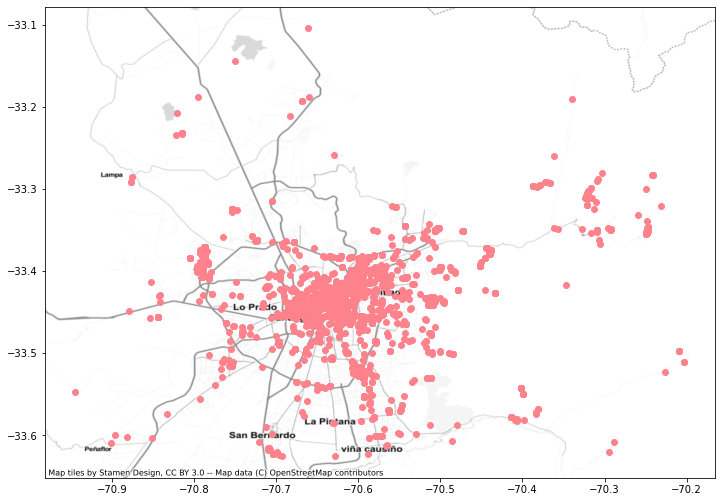

In [100]:
f, ax = plt.subplots(1, figsize=(12, 12))
stgo_flickr_gdf.plot(ax=ax, color='xkcd:blush pink');
#ax.set_axis_off()
cx.add_basemap(ax, crs=stgo_flickr_gdf.crs, source=cx.providers.Stamen.TonerLite)

#### Maps of pictures taken in 2021

In [101]:
stgo_flickr_2020 = pd.read_json('../Chile/Santiago_flickr_photos2020.json')

In [102]:
stgo_flickr2020_gdf = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            stgo_flickr_2020["longitude"], stgo_flickr_2020["latitude"]
        )
    }, crs="EPSG:4326"
).join(stgo_flickr_2020)

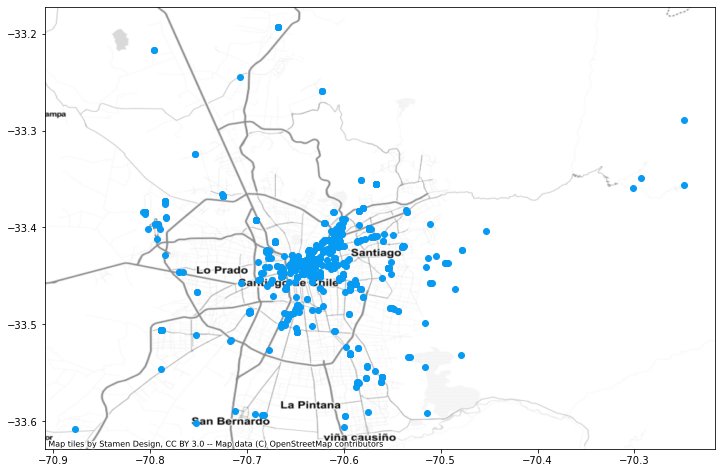

In [103]:
f, ax = plt.subplots(1, figsize=(12, 12))
stgo_flickr2020_gdf.plot(ax=ax, color='xkcd:azure');
#ax.set_axis_off()
cx.add_basemap(ax, crs=stgo_flickr2020_gdf.crs, source=cx.providers.Stamen.TonerLite)

#### Maps of pictures taken in 2022

In [104]:
stgo_flickr_2022 = pd.read_json('../Chile/Santiago_flickr_photos2022.json')

In [105]:
stgo_flickr2022_gdf = gpd.GeoDataFrame(
    {
        "geometry": gpd.points_from_xy(
            stgo_flickr_2022["longitude"], stgo_flickr_2022["latitude"]
        )
    }, crs="EPSG:4326"
).join(stgo_flickr_2022)

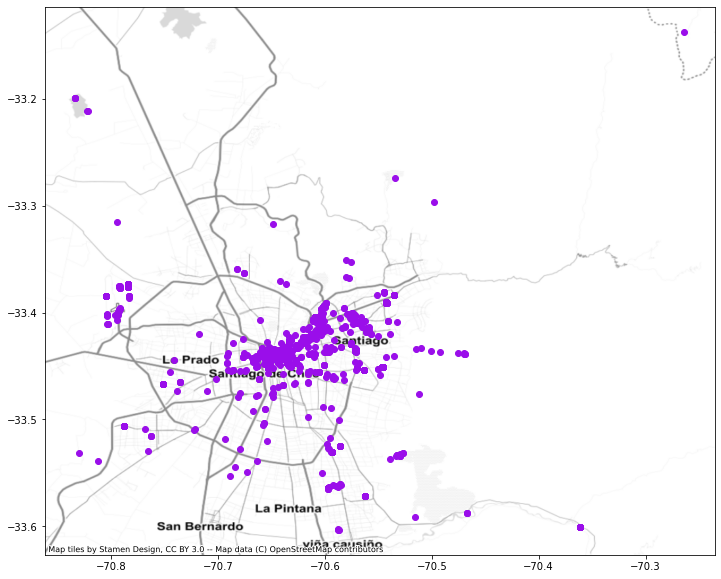

In [106]:
f, ax = plt.subplots(1, figsize=(12, 12))
stgo_flickr2022_gdf.plot(ax=ax, color='xkcd:violet');
#ax.set_axis_off()
cx.add_basemap(ax, crs=stgo_flickr2022_gdf.crs, source=cx.providers.Stamen.TonerLite)

In [107]:
photo_info = ['id', 'url_n', 'latitude','longitude']

#### DBSCAN analysis for pictures taken in 2017-2019

In [108]:
df_flickr_2019 = stgo_flickr[photo_info]

In [110]:
df_flickr_2019.duplicated().sum()

0

In [111]:
df_flickr_2019.drop(['id', 'url_n'], axis=1, inplace=True)

C:\Users\Pablo\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


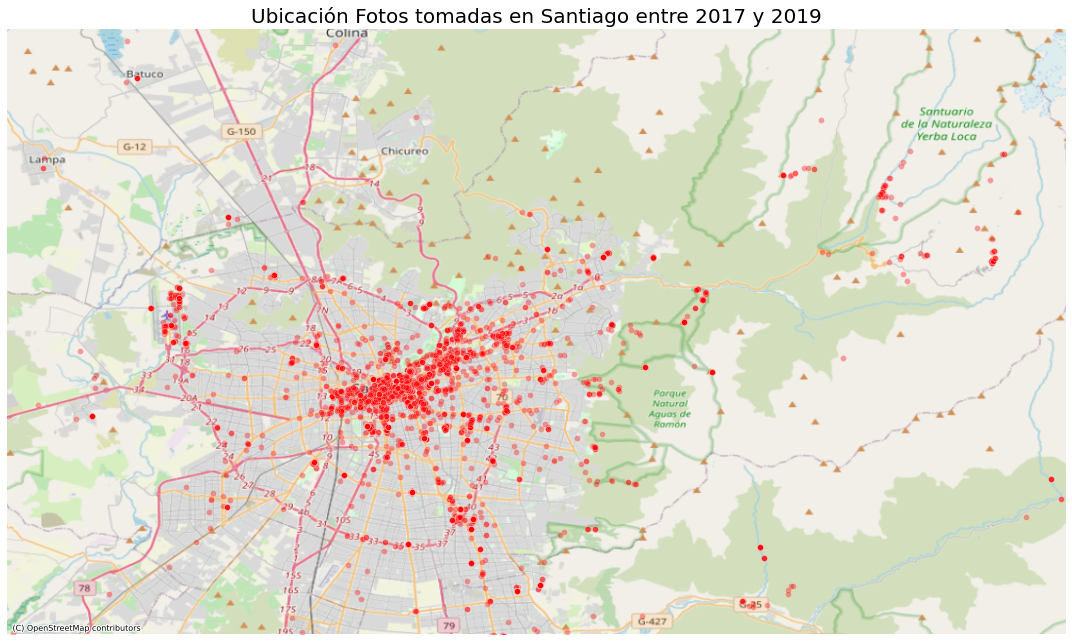

In [112]:
fig, ax = plt.subplots(1, figsize=(15, 15))
plt.title('Ubicación Fotos tomadas en Santiago entre 2017 y 2019', loc='center', fontsize=20)
sns.scatterplot(x=df_flickr_2019.longitude, y=df_flickr_2019.latitude, alpha=.35, ax=ax, color='red')
plt.setp(ax, xlim=(-70.9,-70.2), ylim=(-33.6,-33.2))
ax.set_axis_off()
plt.tight_layout()
cx.add_basemap(ax, crs=stgo_flickr_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik);
#plt.savefig('../Chile/flickr_stgo/flickrstgo2017-2019.jpg', dpi=400, bbox_inches='tight')

In [113]:
# normalization of the data using the min max method
scaler = preprocessing.MinMaxScaler()

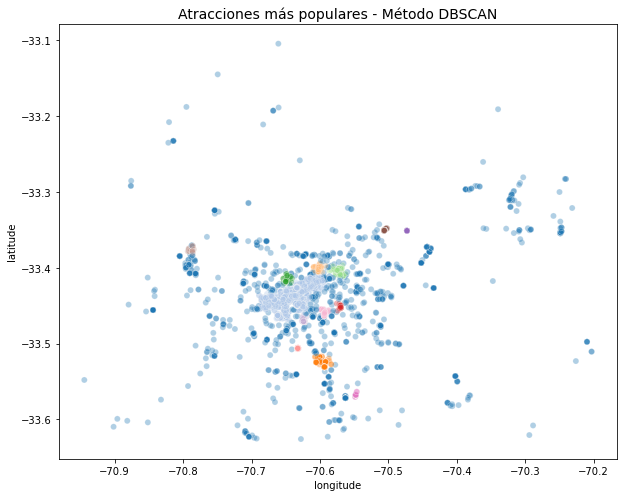

In [114]:
# normalization - fit and transform the data
df_photos_scaled = scaler.fit_transform(df_flickr_2019)

# apply the dbscan algorithm to the dataset
tourist_points = cluster.DBSCAN(eps=0.010, min_samples=35).fit(df_photos_scaled)

# labels of the clusters
labels_tourist_points = tourist_points.labels_

# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Atracciones más populares - Método DBSCAN', loc='center', fontsize=14)
sns.scatterplot(x=df_flickr_2019.longitude, y=df_flickr_2019.latitude, alpha=.35,
                hue=labels_tourist_points, palette="tab20", legend=None);

In [115]:
np.unique(labels_tourist_points)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

In [116]:
# exclude the observations with a label equal to -1. 
df_photos_filtered = df_flickr_2019[tourist_points.labels_ != -1]

# exclude the labels equal to -1
labels_tourist_points_filtered = labels_tourist_points[labels_tourist_points != -1]

In [117]:
# calculate the center of each cluster
mean_location_clusters = []
for group in np.unique(labels_tourist_points_filtered):
    mean_location_clusters.append(list(df_photos_filtered[labels_tourist_points_filtered==group].mean()))

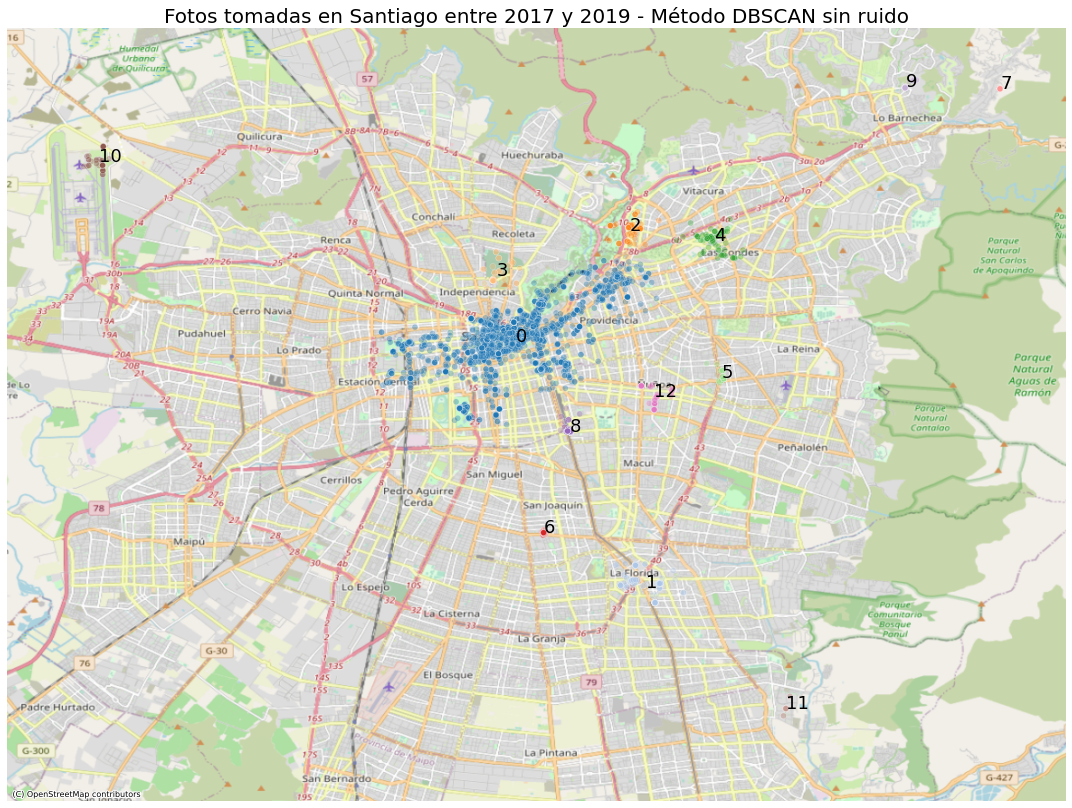

In [118]:
# scatter plot
fig, ax = plt.subplots(1, figsize=(15, 15))
plt.title('Fotos tomadas en Santiago entre 2017 y 2019 - Método DBSCAN sin ruido', loc='center', fontsize=20)
sns.scatterplot(x=df_photos_filtered.longitude, y=df_photos_filtered.latitude, alpha=.35,
                hue=labels_tourist_points_filtered, palette="tab20", legend=None, ax=ax);
plt.setp(ax, xlim=(-70.82,-70.45), ylim=(-33.6,-33.33))
ax.set_axis_off()
plt.tight_layout()
cx.add_basemap(ax, crs=stgo_flickr_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik);
# visualize the label associated to each cluster
for index, location in enumerate(mean_location_clusters):
    plt.text(location[1], location[0], str(index), fontsize=18);
#plt.savefig('../Chile/flickr_stgo/flickrstgo2017-2019_sinruido.jpg', dpi=400, bbox_inches='tight')

#### Represent data with Folium

In [119]:
stgo_map = folium.Map(location=[-33.4724228,-70.6648573], zoom_start=13)

for index, location in enumerate(mean_location_clusters):
    folium.map.Marker(location=[location[0], location[1]],
                      icon=folium.plugins.BeautifyIcon(border_color='green',
                                                       text_color='red',
                                                       number=index,
                                                       icon_shape='marker')).add_to(stgo_map)

stgo_map

#### DBSCAN analysis for pictures taken in 2021-2022

In [120]:
df_flickr_2022 = stgo_flickr_2022[photo_info]

In [122]:
df_flickr_2022.duplicated().sum()

0

In [123]:
df_flickr_2022.drop(['id', 'url_n'], axis=1, inplace=True)

C:\Users\Pablo\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


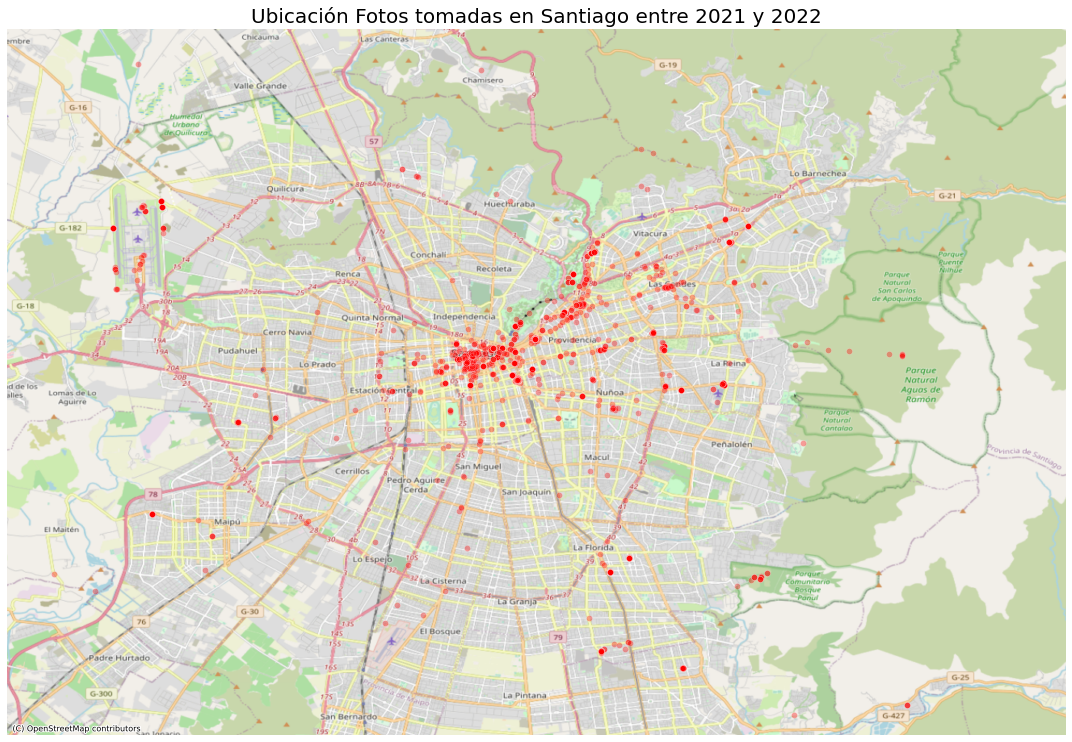

In [124]:
fig, ax = plt.subplots(1, figsize=(15, 15))
plt.title('Ubicación Fotos tomadas en Santiago entre 2021 y 2022', loc='center', fontsize=20)
sns.scatterplot(x=df_flickr_2022.longitude, y=df_flickr_2022.latitude, alpha=.35, ax=ax,color='red')
plt.setp(ax, xlim=(-70.85,-70.4), ylim=(-33.6,-33.3))
ax.set_axis_off()
plt.tight_layout()
cx.add_basemap(ax, crs=stgo_flickr_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik);
#plt.savefig('../Chile/flickr_stgo/flickrstgo2021-2022.jpg', dpi=400, bbox_inches='tight')

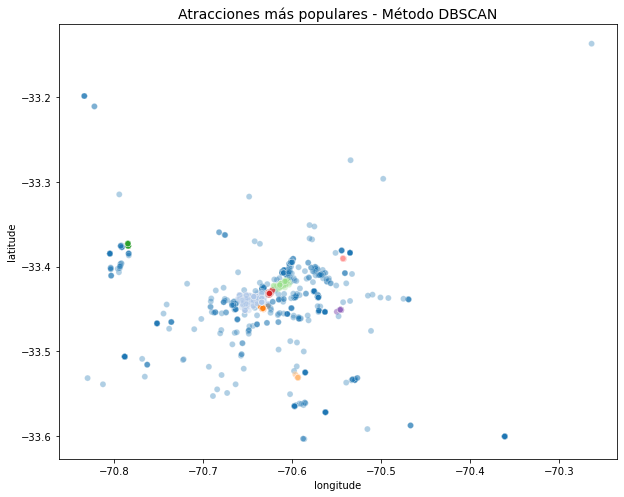

In [125]:
# normalization - fit and transform the data
df_photos_scaled = scaler.fit_transform(df_flickr_2022)

# apply the dbscan algorithm to the dataset
tourist_points = cluster.DBSCAN(eps=0.010, min_samples=35).fit(df_photos_scaled)

# labels of the clusters
labels_tourist_points = tourist_points.labels_

# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Atracciones más populares - Método DBSCAN', loc='center', fontsize=14)
sns.scatterplot(x=df_flickr_2022.longitude, y=df_flickr_2022.latitude, alpha=.35,
                hue=labels_tourist_points, palette="tab20", legend=None);

In [126]:
np.unique(labels_tourist_points)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

In [127]:
# exclude the observations with a label equal to -1. 
df_photos_filtered = df_flickr_2022[tourist_points.labels_ != -1]

# exclude the labels equal to -1
labels_tourist_points_filtered = labels_tourist_points[labels_tourist_points != -1]

In [128]:
# calculate the center of each cluster
mean_location_clusters = []
for group in np.unique(labels_tourist_points_filtered):
    mean_location_clusters.append(list(df_photos_filtered[labels_tourist_points_filtered==group].mean()))

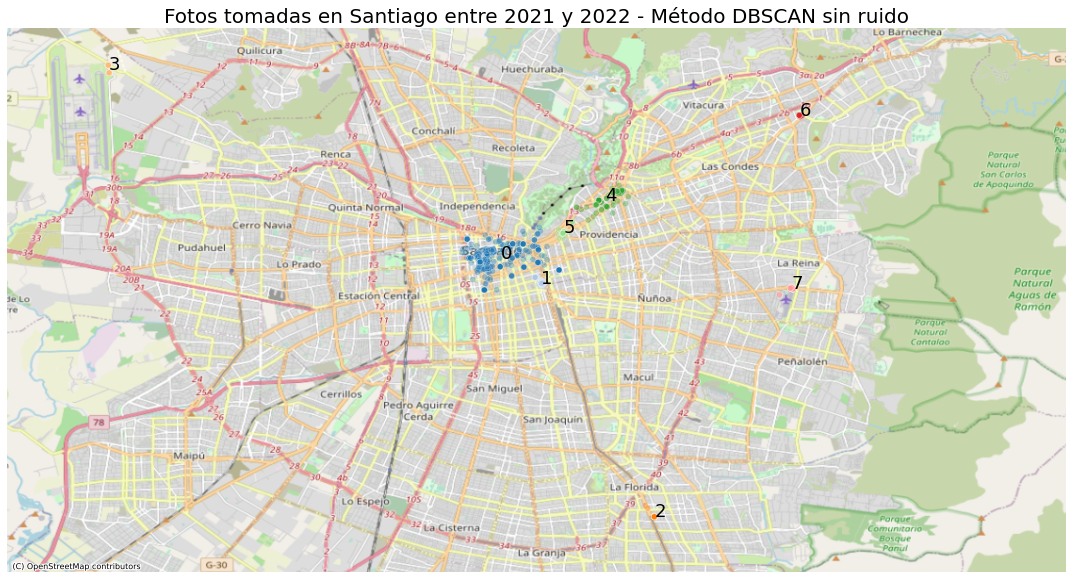

In [129]:
fig, ax = plt.subplots(1, figsize=(15, 15))
plt.title('Fotos tomadas en Santiago entre 2021 y 2022 - Método DBSCAN sin ruido', loc='center', fontsize=20)
sns.scatterplot(x=df_photos_filtered.longitude, y=df_photos_filtered.latitude, alpha=.35,
                hue=labels_tourist_points_filtered, palette="tab20", legend=None, ax=ax);
plt.setp(ax, xlim=(-70.82,-70.45), ylim=(-33.55,-33.36))
ax.set_axis_off()
plt.tight_layout()
cx.add_basemap(ax, crs=stgo_flickr_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik);

for index, location in enumerate(mean_location_clusters):
    plt.text(location[1], location[0], str(index), fontsize=18);
#plt.savefig('../Chile/flickr_stgo/flickrstgo2021-2022_sinruido.jpg', dpi=400, bbox_inches='tight')

In [130]:
stgo_map2 = folium.Map(location=[-33.4724228,-70.6648573], zoom_start=13)

for index, location in enumerate(mean_location_clusters):
    folium.map.Marker(location=[location[0], location[1]],
                      icon=folium.plugins.BeautifyIcon(border_color='green',
                                                       text_color='red',
                                                       number=index,
                                                       icon_shape='marker')).add_to(stgo_map2)

stgo_map2